Update: Study the relation between classification accuracy and quantity of labeled and unlabeled documents.

In [1]:
# Import packages and libraries
import numpy as np
import random as rnd
import re
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn import metrics

from time import time
from pprint import pprint
from copy import deepcopy
from wordcloud import WordCloud 
from Semi_EM_NB import Semi_EM_MultinomialNB
from os import path
from PIL import Image

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
def remove_noise(sentence):
    result = ''
    poster = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stopword_set = set(stopwords.words('english'))
    wordlist = re.sub(r"\n|(\\(.*?){)|}|[!$%^&*#()_+|~\-={}\[\]:\";'<>?,.\/\\]|[0-9]|[@]", ' ', sentence) # remove punctuation
    wordlist = re.sub('\s+', ' ', wordlist) # remove extra space
    wordlist_normal = [poster.stem(word.lower()) for word in wordlist.split()] # restore word to its original form (stemming)
    wordlist_normal = [lemmatizer.lemmatize(word, pos='v') for word in wordlist_normal] # restore word to its root form (lemmatization)
    wordlist_clean = [word for word in wordlist_normal if word not in stopword_set] # remove stopwords
    result = ' '.join(wordlist_clean)
    return result

In [3]:
def cross_validation(clf, data_X, data_y, unlabeled=None, n_folds=5):
    print('=' * 80)
    print("Validation: ")
    print(clf)
    kf = StratifiedKFold(n_splits=n_folds)
    start_time = time()
    train_scores = list() # training accuracy
    fold_count = 1
    original_clf = deepcopy(clf)
    avg_accuracy = 0
    for train_ids, valid_ids in kf.split(data_X, data_y):
        cv_clf = deepcopy(original_clf)
        print("Fold # %d" % fold_count)
        fold_count += 1
        train_X, train_y, valid_X, valid_y = data_X[train_ids], data_y[train_ids], data_X[valid_ids], data_y[valid_ids]
        if unlabeled==None:
            cv_clf.fit(train_X, train_y)
        else:
            cv_clf.fit(train_X, train_y, unlabeled)
        pred = cv_clf.predict(valid_X)
        scores = dict()
        scores['accuracy'] = metrics.accuracy_score(valid_y, pred)
        scores['recall'] = metrics.recall_score(valid_y, pred, average='macro')
        scores['precision'] = metrics.precision_score(valid_y, pred, average='macro')
        scores['f1_score'] = metrics.f1_score(valid_y, pred, average='macro')
        train_scores.append(scores)
        avg_accuracy += scores['accuracy']
    train_time = time() - start_time
    print("Validation time: %0.3f seconds" % train_time)
    print("Average training accuracy: %0.3f" % (avg_accuracy/n_folds))
    return train_scores, train_time

In [4]:
def show_topK(classifier, vectorizer, categories, K=10):
    feature_names = np.asarray(vectorizer.get_feature_names())
    nrows, ncols = 5, 4
    fig, axes = plt.subplots(figsize=(50, 40), nrows=nrows, ncols=ncols)
    #d = path.dirname(__file__)
    circle_mask = np.array(Image.open(path.join('./', "circle.png")))
    for i, category in enumerate(categories):
        topK = np.argsort(classifier.coef_[i])[-K:]
        text = " ".join(feature_names[topK])
        print("%s: %s" % (category, text))
        wordcloud = WordCloud(background_color="white", mask=circle_mask).generate(text)
        axes[i//ncols, i%ncols].imshow(wordcloud, cmap=plt.cm.cool_r, interpolation='bilinear')
        axes[i//ncols, i%ncols].axis("off")
        axes[i//ncols, i%ncols].set_title(category, fontweight="bold", size=24)
    plt.show()

In [5]:
# Load data set with class labels and split into train and test set
test_size_ratio = 0.2
data_Xy = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
category_names = data_Xy.target_names # text names of all categories
train_X, test_X, train_y, test_y = train_test_split(data_Xy.data, data_Xy.target, test_size=test_size_ratio, stratify=data_Xy.target)
print("Training set size: %8d\tTest set size: %8d" % (len(train_X), len(test_X)))

Training set size:    15076	Test set size:     3770


In [6]:
# preprocess train and test text data
train_X_clean = map(remove_noise, train_X)
test_X_clean = map(remove_noise, test_X)

In [7]:
# Convert all text data into tf-idf vectors 
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.95)
# vectorizer = TfidfVectorizer()
train_vec = vectorizer.fit_transform(train_X_clean)
test_vec = vectorizer.transform(test_X_clean)
print train_vec.shape, test_vec.shape

(15076, 13108) (3770, 13108)


In [8]:
# Divide train data set into labeled and unlabeled data sets
split_ratio = 0.2 # labeled vs total(labeled+unlabeled)
# X_l, X_u, y_l, y_u = train_test_split(train_vec, train_y, train_size=split_ratio, stratify=train_y)
X_l, X_u, y_l, y_u = train_test_split(train_vec, train_y, test_size=10000, stratify=train_y)
experiments = np.logspace(2.3, 3.7, num=10, base=10, dtype='int')
print X_l.shape, X_u.shape

(5076, 13108) (10000, 13108)


In [9]:
# Cross validation for Naive Bayes classifier 
# using labeled data set only
nb_cv_scores = list()
nb_cv_times = list()
for n_l_docs in experiments:
    nb_clf = MultinomialNB(alpha=1e-2)
    cv_scores, cv_time = cross_validation(nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs])
    nb_cv_scores.append(cv_scores)
    nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.089 seconds
Average training accuracy: 0.472
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.099 seconds
Average training accuracy: 0.419
Number of labeled documents:    285
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.093 seconds
Average training accuracy: 0.477
Number of labeled documents:    408
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.080 seconds
Average training accuracy: 0.502
Number of labeled documents:    584
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation

/Users/Jerry/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/Jerry/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Jerry/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
# Cross validation for semisupervised EM Naive Bayes classifier 
# using both labeled and unlabeled data set
em_nb_cv_scores = list()
em_nb_cv_times = list()
for n_l_docs in experiments:
    em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False) # semi supervised EM based Naive Bayes classifier
    cv_scores, cv_time = cross_validation(em_nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs], X_u)
    em_nb_cv_scores.append(cv_scores)
    em_nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 126.932 seconds
Average training accuracy: 0.528
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 122.787 seconds
Average training accuracy: 0.473
Number of labeled documents:    285
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 107.394 seconds
Average training accuracy: 0.543
Number of labeled documents:    408
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 103.714 seconds
Average training accuracy: 0.539
Number of labeled documents:    584
Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Va

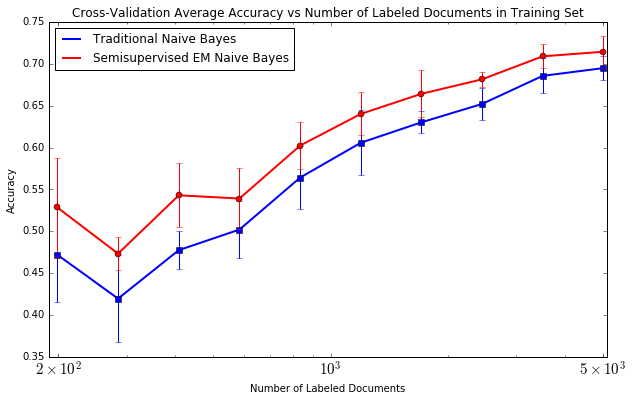

In [11]:
# plot CV accuracy comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['accuracy'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['accuracy'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_mean, color='b', linewidth=2, label='Traditional Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax.plot(experiments, em_nb_score_mean, color='r', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Cross-Validation Average Accuracy vs Number of Labeled Documents in Training Set')

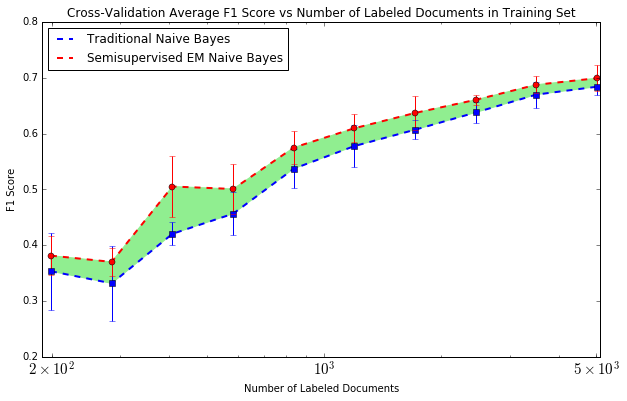

In [12]:
# plot CV F1 Score comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['f1_score'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['f1_score'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_mean, color='b', linestyle='--', linewidth=2, label='Traditional Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax.plot(experiments, em_nb_score_mean, color='r', linestyle='--', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='lightgreen')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('F1 Score')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Cross-Validation Average F1 Score vs Number of Labeled Documents in Training Set')

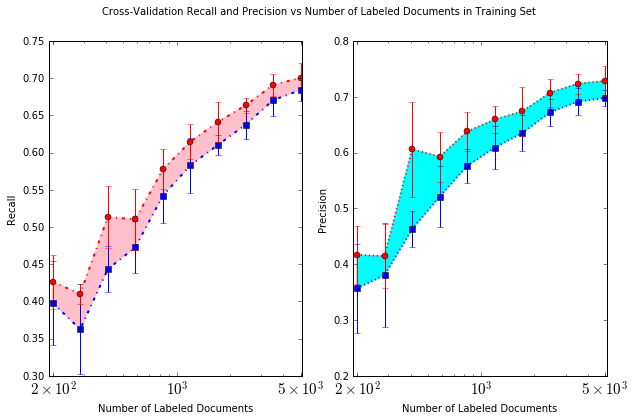

In [13]:
# plot CV accuracy comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['recall'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['recall'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax1.plot(experiments, nb_score_mean, color='b', linestyle='-.', linewidth=2, label='Traditional Naive Bayes')
ax1.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax1.plot(experiments, em_nb_score_mean, color='r', linestyle='-.', linewidth=2, label='Semisupervised EM Naive Bayes')
ax1.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax1.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='pink')
ax1.set_xlabel('Number of Labeled Documents')
ax1.set_ylabel('Recall')
ax1.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax1.set_xscale('log')
ax1.set_xticks([200, 1000, 5000]) 
ax1.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['precision'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['precision'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
ax2 = fig.add_subplot(122)
ax2.plot(experiments, nb_score_mean, color='b', linestyle=':', linewidth=2, label='Traditional Naive Bayes')
ax2.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax2.plot(experiments, em_nb_score_mean, color='r', linestyle=':', linewidth=2, label='Semisupervised EM Naive Bayes')
ax2.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax2.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='aqua')
ax2.set_xlabel('Number of Labeled Documents')
ax2.set_ylabel('Precision')
ax2.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax2.set_xscale('log')
ax2.set_xticks([200, 1000, 5000]) 
ax2.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
fig.suptitle('Cross-Validation Recall and Precision vs Number of Labeled Documents in Training Set')
plt.show()

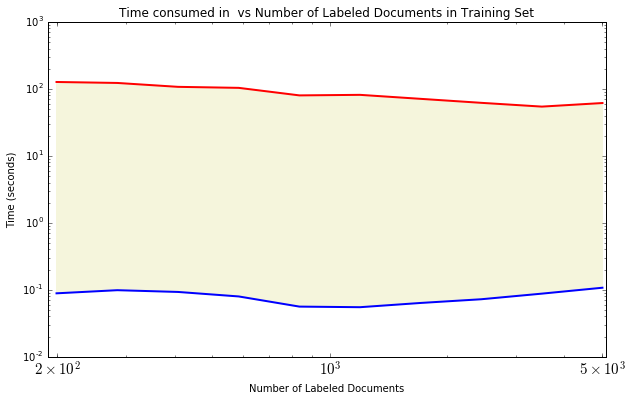

In [14]:
# plot time consuming in EM NB training process
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_cv_times, color='b', linewidth=2, label='Traditional Naive Bayes')
ax.plot(experiments, em_nb_cv_times, color='r', linestyle='-', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.fill_between(experiments, nb_cv_times, em_nb_cv_times, color='beige')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Time (seconds)')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.title('Time consumed in  vs Number of Labeled Documents in Training Set')

In [15]:
# Evaluate original NB classifier using test data set
nb_test_scores = dict()
nb_test_scores['accuracy'] = list()
nb_test_scores['recall'] = list()
nb_test_scores['precision'] = list()
nb_test_scores['f1_score'] = list()
for n_l_docs in experiments:
    nb_clf = MultinomialNB(alpha=1e-2).fit(X_l[:n_l_docs,], y_l[:n_l_docs])
    pred = nb_clf.predict(test_vec)
    accuracy = metrics.accuracy_score(test_y, pred)
    nb_test_scores['accuracy'].append(accuracy)
    nb_test_scores['recall'].append(metrics.recall_score(test_y, pred, average='macro'))
    nb_test_scores['precision'].append(metrics.precision_score(test_y, pred, average='macro'))
    nb_test_scores['f1_score'].append(metrics.f1_score(test_y, pred, average='macro'))
    print("%6d labeled documents lead to accuracy of %.3f" % (n_l_docs, accuracy))

   199 labeled documents lead to accuracy of 0.362
   285 labeled documents lead to accuracy of 0.411
   408 labeled documents lead to accuracy of 0.468
   584 labeled documents lead to accuracy of 0.512
   836 labeled documents lead to accuracy of 0.568
  1196 labeled documents lead to accuracy of 0.602
  1711 labeled documents lead to accuracy of 0.625
  2448 labeled documents lead to accuracy of 0.656
  3503 labeled documents lead to accuracy of 0.683
  5011 labeled documents lead to accuracy of 0.696


In [16]:
# Evaluate semi-supervised EM NB classifier using test data set
em_nb_test_scores = dict()
em_nb_test_scores['accuracy'] = list()
em_nb_test_scores['recall'] = list()
em_nb_test_scores['precision'] = list()
em_nb_test_scores['f1_score'] = list()
for n_l_docs in experiments:
    em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False).fit(X_l[:n_l_docs,], y_l[:n_l_docs], X_u)
    pred = em_nb_clf.predict(test_vec)
    accuracy = metrics.accuracy_score(test_y, pred)
    em_nb_test_scores['accuracy'].append(accuracy)
    em_nb_test_scores['recall'].append(metrics.recall_score(test_y, pred, average='macro'))
    em_nb_test_scores['precision'].append(metrics.precision_score(test_y, pred, average='macro'))
    em_nb_test_scores['f1_score'].append(metrics.f1_score(test_y, pred, average='macro'))
    print("%6d labeled documents lead to accuracy of %.3f" % (n_l_docs, accuracy))

   199 labeled documents lead to accuracy of 0.423
   285 labeled documents lead to accuracy of 0.478
   408 labeled documents lead to accuracy of 0.554
   584 labeled documents lead to accuracy of 0.593
   836 labeled documents lead to accuracy of 0.627
  1196 labeled documents lead to accuracy of 0.647
  1711 labeled documents lead to accuracy of 0.660
  2448 labeled documents lead to accuracy of 0.674
  3503 labeled documents lead to accuracy of 0.690
  5011 labeled documents lead to accuracy of 0.707


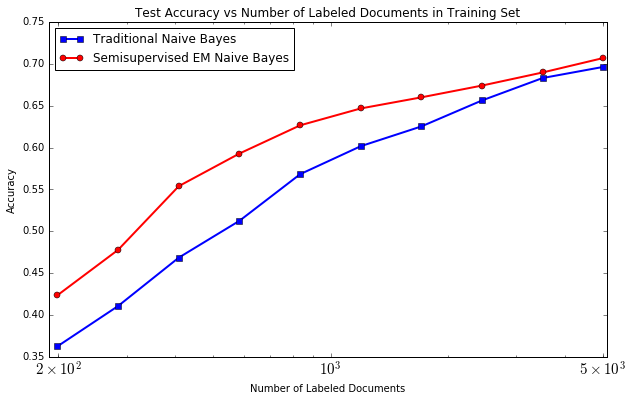

In [17]:
# Plot and compare test accuracy metrics
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_test_scores['accuracy'], color='b', marker='s', linewidth=2, label='Traditional Naive Bayes')
ax.plot(experiments, em_nb_test_scores['accuracy'], color='r', marker='o', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Test Accuracy vs Number of Labeled Documents in Training Set')

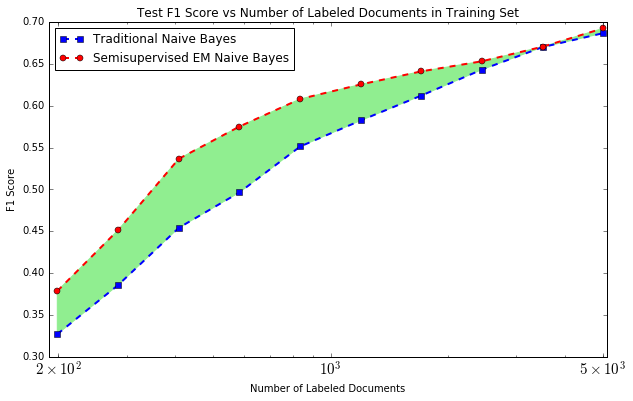

In [18]:
# Plot and compare test f1 score metrics
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_test_scores['f1_score'], color='b', marker='s', linestyle='--', linewidth=2, label='Traditional Naive Bayes')
ax.plot(experiments, em_nb_test_scores['f1_score'], color='r', marker='o', linestyle='--', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.fill_between(experiments, nb_test_scores['f1_score'], em_nb_test_scores['f1_score'], color='lightgreen')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('F1 Score')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Test F1 Score vs Number of Labeled Documents in Training Set')

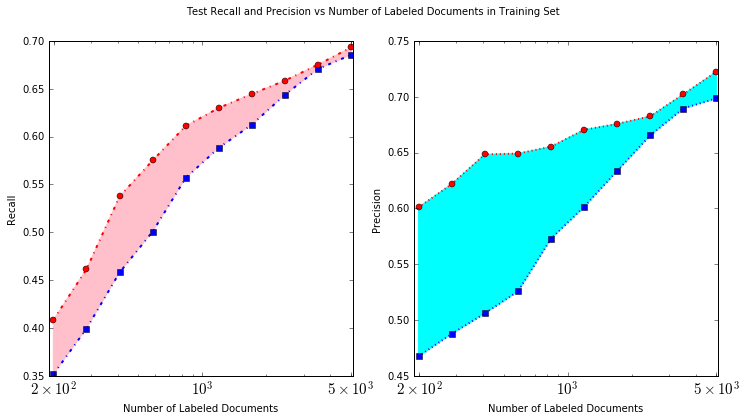

In [19]:
# Plot and compare test recall and precisions metrics
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(experiments, nb_test_scores['recall'], color='b', marker='s', linestyle='-.', linewidth=2, label='Traditional Naive Bayes')
ax1.plot(experiments, em_nb_test_scores['recall'], color='r', marker='o', linestyle='-.', linewidth=2, label='Semisupervised EM Naive Bayes')
ax1.fill_between(experiments, nb_test_scores['recall'], em_nb_test_scores['recall'], color='pink')
ax1.set_xlabel('Number of Labeled Documents')
ax1.set_ylabel('Recall')
ax1.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax1.set_xscale('log')
ax1.set_xticks([200, 1000, 5000]) 
ax1.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)

ax2 = fig.add_subplot(122)
ax2.plot(experiments, nb_test_scores['precision'], color='b', marker='s', linestyle=':', linewidth=2, label='Traditional Naive Bayes')
ax2.plot(experiments, em_nb_test_scores['precision'], color='r', marker='o', linestyle=':', linewidth=2, label='Semisupervised EM Naive Bayes')
ax2.fill_between(experiments, nb_test_scores['precision'], em_nb_test_scores['precision'], color='aqua')
ax2.set_xlabel('Number of Labeled Documents')
ax2.set_ylabel('Precision')
ax2.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax2.set_xscale('log')
ax2.set_xticks([200, 1000, 5000]) 
ax2.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
fig.suptitle('Test Recall and Precision vs Number of Labeled Documents in Training Set')
plt.show()

alt.atheism: thing like ha becaus punish whi mean belief object read know delet atheism ani argument muslim islam believ post claim make peopl think religion moral say wa atheist god thi
comp.graphics: code like vga mail vesa display softwar wa need polygon bite gif look screen color pleas convert doe help program anyon ani know use thank format thi imag graphic file
comp.os.ms-windows.misc: set app chang ha help work printer microsoft pc ftp anyon manag cica like font version ani win problem thank tri ms run program driver os thi use file window
comp.sys.ibm.pc.hardware: pleas set board doe like motherboard ram problem floppi comput run monitor disk work isa control pc port ani thank driver mb ide bu use thi dx card scsi drive
comp.sys.mac.hardware: video rom quadra speed wa simm cd lc duo machin scsi card like buy anyon thank doe know ani ha mhz monitor work problem use thi centri drive appl mac
comp.windows.x: set like ha xterm know sourc work edu anyon appreci event mit doe color c

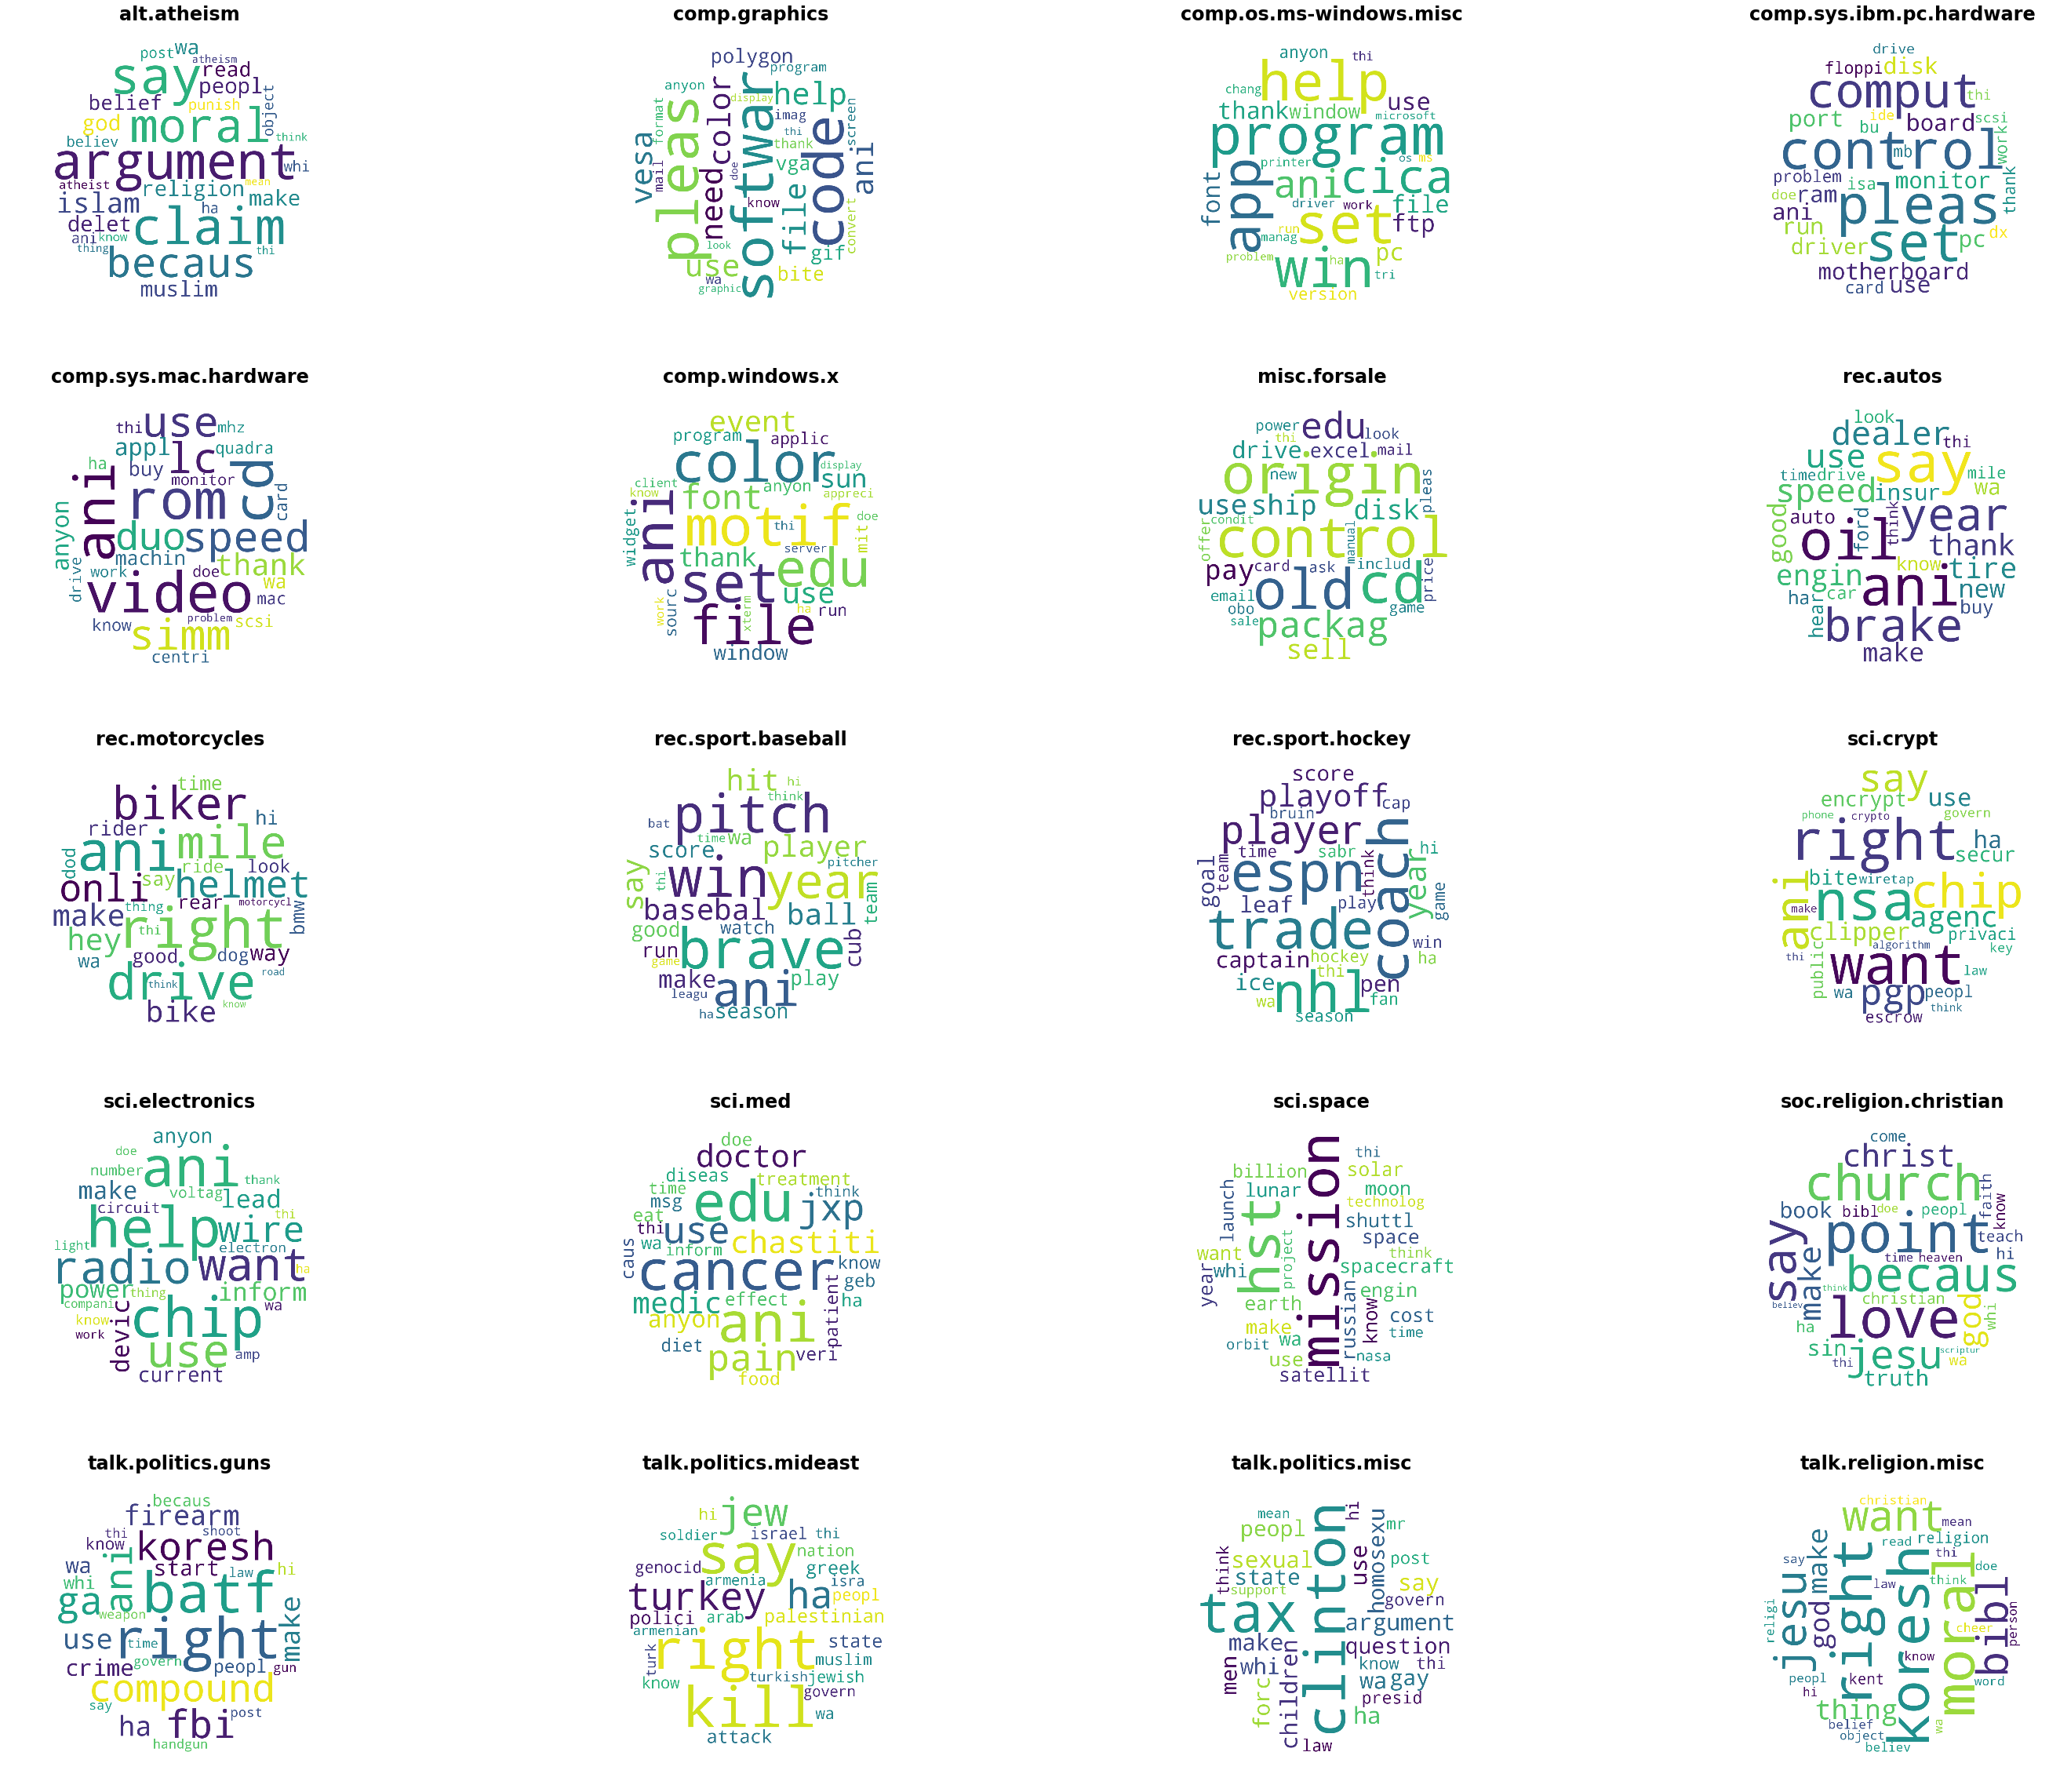

In [20]:
show_topK(nb_clf, vectorizer, category_names, K=30) # keywords for each class by original NB classifier

alt.atheism: doe point thing word know becaus whi mean claim ani statement argument atheism delet object make belief exist believ islam post religion peopl think wa atheist moral say god thi
comp.graphics: softwar comput display window like post advanc ftp need code mail color bite convert help gif look doe use pleas know program anyon ani format thi thank imag file graphic
comp.os.ms-windows.misc: cica pleas help doe ha microsoft tri work pc anyon manag know like ftp ms printer version win ani thank problem os run font driver thi program use file window
comp.sys.ibm.pc.hardware: isa set know ha run window anyon doe bio work board monitor motherboard port problem pc thank ani disk driver control bu mb dx ide thi use scsi card drive
comp.sys.mac.hardware: se upgrad video modem comput like speed price quadra buy doe lc anyon centri machin simm ha know thank ani work mhz problem card use monitor thi drive appl mac
comp.windows.x: ha anyon edu like doe help font color mit set code work cli

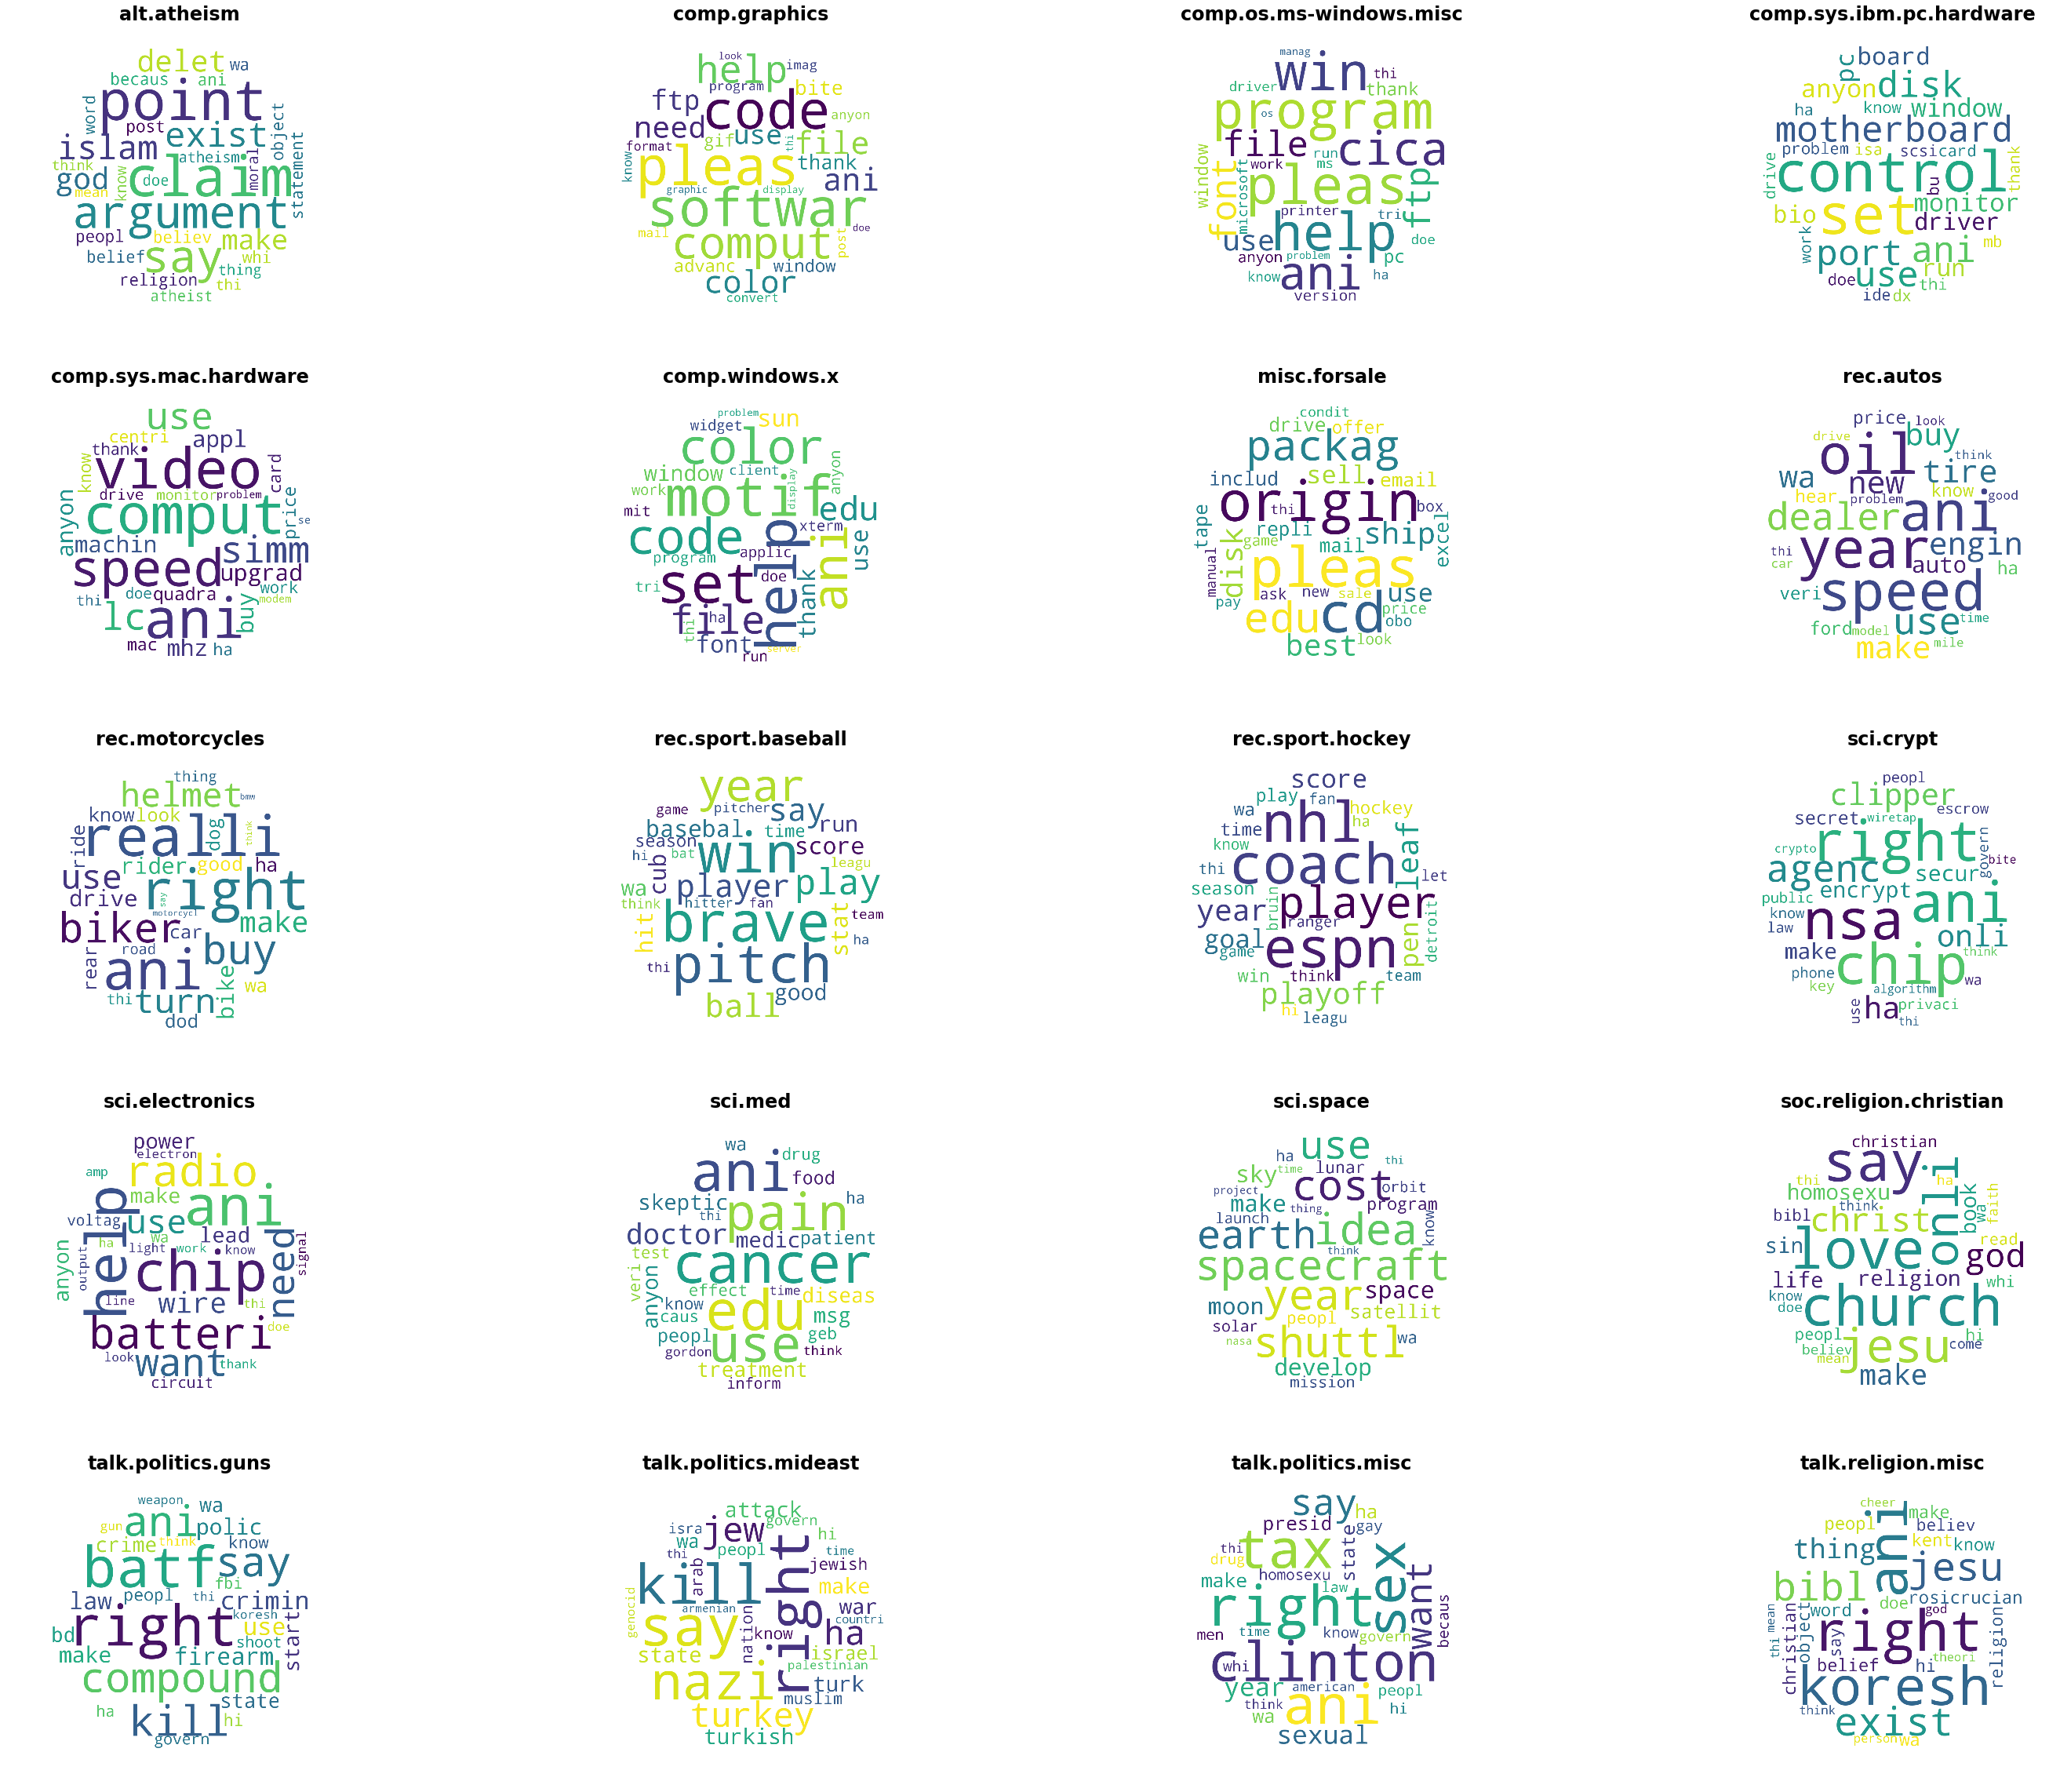

In [21]:
show_topK(em_nb_clf, vectorizer, category_names, K=30) # keywords for each class by semisupervised EM NB classifier